In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [0]:
# 배치 사이즈 설정
batch_size = 64

# MNIST 데이터 세트를 이용합니다.
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False,
                              transform=transforms.ToTensor())

In [0]:
# 데이터 로더를 이용하여 데이터를 불러올 수 있습니다.
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
# 임의의 이미지 분류 딥 뉴럴 네트워크 선언
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.l1 = nn.Linear(784, 520) # 입력층
        self.l2 = nn.Linear(520, 320)
        self.l3 = nn.Linear(320, 240)
        self.l4 = nn.Linear(240, 120)
        self.l5 = nn.Linear(120, 10) # 10개로 분류

    def forward(self, x):
        x = x.view(-1, 784)  # (배치 사이즈, 1, 28, 28) 크기의 데이터를 (배치 사이즈, 784) 형태로 변경합니다.
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)


model = Net()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [0]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.8f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data))
            
# 배치 한 번에 대한 data와 target 정보 가져오기
get_data = []
get_target = []
got = False 

def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        global got
        if not got:
          get_data.append(data)
          get_target.append(target)
          got = True
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).data
        # get the index of the max
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [0]:
# 학습 수행
for epoch in range(0, 10):
  train(epoch)
  test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.29774189
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.31107497
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.30224872
Train Epoch: 0 [19200/60000 (32%)]	Loss: 2.28736734
Train Epoch: 0 [25600/60000 (43%)]	Loss: 2.28284836
Train Epoch: 0 [32000/60000 (53%)]	Loss: 2.27490926
Train Epoch: 0 [38400/60000 (64%)]	Loss: 2.24955773
Train Epoch: 0 [44800/60000 (75%)]	Loss: 2.23057199
Train Epoch: 0 [51200/60000 (85%)]	Loss: 2.14722085
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.90413511


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.



Test set: Average loss: 0.0272, Accuracy: 4427/10000 (44%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.80065191
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.42838001
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.95072317
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.73783684
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.67243677
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.72282821
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.76012862
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.61376834
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.57562184
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.54321486

Test set: Average loss: 0.0067, Accuracy: 8717/10000 (87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.47642353
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.26871383
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.54879725
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.23233993
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.33285114
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.30322838
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.31908777
Train 

In [0]:
# FGSM attack code
def fgsm_attack(data, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_data = data + epsilon * sign_data_grad
    # Return the perturbed image
    return perturbed_data

숫자 이미지 X의 크기: torch.Size([1, 28, 28])


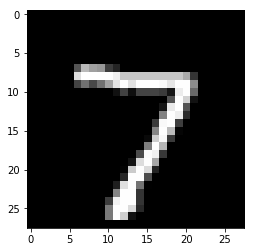

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# FGSM attack code
def fgsm_attack(data, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbation = epsilon * sign_data_grad
    # Return the perturbed image
    return perturbation

image_data = get_data[0][0] # 첫 번째 숫자 X
print('숫자 이미지 X의 크기:', image_data.size())
plt.imshow(image_data.numpy()[0], cmap='gray')

X의 판정 결과: tensor([[ -2.3541,   0.1431,   3.0336,   5.0114,  -8.6109,  -2.4930, -14.8356,
          12.9158,   1.0161,   5.5949]], grad_fn=<AddmmBackward>)
X의 분류 값: tensor([7])
Y에 대한 X의 Loss 값: tensor(0.0011, grad_fn=<NllLossBackward>)
Perturbation의 예측 결과:  tensor([[ -0.6863,   0.5825,  -0.5751,   2.1612,  -4.5268,   8.1236,   5.0366,
         -10.4269,   4.6869,  -3.3598]], grad_fn=<AddmmBackward>)


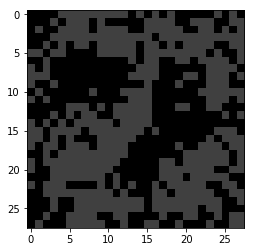

In [0]:
image_data.requires_grad = True
target_value = torch.chunk(get_target[0], 64, dim=0)[0] # 첫 번째 숫자 X의 원래 분류 값
expect_value = model(image_data) # 첫 번째 숫자 X의 예측 결과 계산
print('X의 판정 결과:', expect_value)
print('X의 분류 값:', target_value)

# 원래 분류 값에 대한 Loss의 기울기 계산
loss = criterion(expect_value, target_value)
print('Y에 대한 X의 Loss 값:', loss)

# 역전파 수행
loss.backward()
# 각 차원(픽셀)에 따른 기울기 값 계산
data_grad = image_data.grad.data

# 그냥 부호만 채택하여 입실론 만큼 곱하기
perturbation = fgsm_attack(image_data, 0.25, data_grad)

# 만들어진 Perturbation 가져오기
perturbation = perturbation[0]
output = model(perturbation)
print('Perturbation의 예측 결과: ', output)

perturbation_image = perturbation.detach().numpy() # Perturbation 이미지 출력을 위한 Numpy 변환
plt.imshow(perturbation_image, cmap='gray', vmin=0, vmax=1) # 출력할 때 최소는 0, 최대는 1로 설정해야 정상 동작

Adversarial Example의 판정 결과: tensor([[ -0.2700,  -1.1158,  -0.1620,   9.5920, -13.2958,   9.7336,  -4.0752,
          -7.0577,   6.1908,   1.4546]], grad_fn=<AddmmBackward>)
가장 가까운 숫자: tensor([[5]])
Y에 대한 Adversarial Example의 Loss 값: tensor(17.4318, grad_fn=<NllLossBackward>)


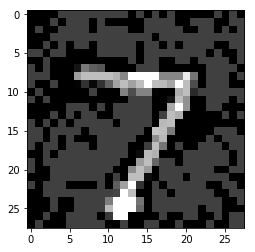

In [0]:
# 최종적으로 만들어진 Adversarial Example
adversarial_example = image_data + perturbation
adversarial_example = torch.clamp(adversarial_example, 0, 1) # 0부터 1사이의 값이 아니라면 가지치기
plt.imshow(adversarial_example.detach().numpy()[0], cmap='gray', vmin=0, vmax=1)

# Adversarial Example의 예측 결과 계산
expect_value = model(adversarial_example)
print('Adversarial Example의 판정 결과:', expect_value)
print('가장 가까운 숫자:', expect_value.data.max(1, keepdim=True)[1])

# 원래 분류 값에 대한 Loss의 기울기 계산
loss = criterion(expect_value, target_value)
print('Y에 대한 Adversarial Example의 Loss 값:', loss)